Analysis of LiLa field test data
-----------
Author: Albert Ulmer  
Date: May 2022  

In [12]:
# autoreload packages
%load_ext autoreload
%autoreload 2

# libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
import datetime as dt

import myfunctions as mf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# parameters
phases = {}
phases["phase1"] = pd.Timestamp("2022-03-07 00:00:00.000000")
phases["phase2"] = pd.Timestamp("2022-03-14 00:00:00.000000")
phases["phase3"] = pd.Timestamp("2022-03-21 00:00:00.000000")
phases["phase4"] = pd.Timestamp("2022-03-28 00:00:00.000000")
phases["end"] = pd.Timestamp("2022-04-04 00:00:00.000000")

# constants
freq = '15T'

In [14]:
# connect to SQLite database
try:
    conn = sqlite3.connect('../../data/lila/purple.sqlite3')
    print('Connected to database...')
except:
    print('Database error!')
    exit()


Connected to database...


In [15]:
### Set global flag whether to save plots to files or not
writefiles = 1

if writefiles:
    print("Writing output files!")
else:
    print("Leaving files alone!")


Writing output files!


In [16]:
### Set global flag whether to print debug messages while running code
showdebug = 1

if showdebug:
    print("Showing debug messages!")
else:
    print("No debug messages will be shown!")

Showing debug messages!


## Charging Comfort

### get data

In [17]:
# execute SQL query
querycc = open("sqls/cars_with_wallboxes_15min_v2.sql").read()
dfcc = pd.read_sql_query(querycc, conn)

# fix datatypes
dfcc["timestamp"] =  pd.to_datetime(dfcc["timestamp"]) 

# filter to daterange of field test
dfcc = dfcc[(dfcc["timestamp"] >= phases["phase1"]) & (dfcc["timestamp"] < phases["end"])]

# set index
dfcc.set_index(['vehicle', 'timestamp'], inplace=True, drop=True)
dfcc.head()


status state  activePower-W  stateOfCharge  \
vehicle timestamp                                                        
car1    2022-03-07 00:00:00   idle     0            0.0            0.0   
        2022-03-07 00:15:00   idle     0            0.0            0.0   
        2022-03-07 00:30:00   idle     0            0.0            0.0   
        2022-03-07 00:45:00   idle     0            0.0            0.0   
        2022-03-07 01:00:00   idle     0            0.0            0.0   

                             chgSOC  charging  loadable  driving  
vehicle timestamp                                                 
car1    2022-03-07 00:00:00     0.0         0         0        0  
        2022-03-07 00:15:00     0.0         0         0        0  
        2022-03-07 00:30:00     0.0         0         0        0  
        2022-03-07 00:45:00     0.0         0         0        0  
        2022-03-07 01:00:00     0.0         0         0        0

In [18]:
# load EV data and add features
dfcc2 = mf.load_ev_data(dfcc, phases, freq)
dfcc2.head()


status state  stateOfCharge  chgSOC  \
vehicle timestamp                                                 
car1    2022-03-07 00:00:00   idle   0.0            0.0     0.0   
        2022-03-07 00:15:00   idle   0.0            0.0     0.0   
        2022-03-07 00:30:00   idle   0.0            0.0     0.0   
        2022-03-07 00:45:00   idle   0.0            0.0     0.0   
        2022-03-07 01:00:00   idle   0.0            0.0     0.0   

                             activePower-W  loadable  charging  driving  \
vehicle timestamp                                                         
car1    2022-03-07 00:00:00            0.0       0.0       0.0      0.0   
        2022-03-07 00:15:00            0.0       0.0       0.0      0.0   
        2022-03-07 00:30:00            0.0       0.0       0.0      0.0   
        2022-03-07 00:45:00            0.0       0.0       0.0      0.0   
        2022-03-07 01:00:00            0.0       0.0       0.0      0.0   

                             loadend  driveend  loadbeg  drivebeg        date  \
vehicle timestamp                                                               
car1    2022-03-07 00:00:00    False     False    False     False  2022-03-07   
        2022-03-07 00:15:00    False     False    False     False  2022-03-07   
        2022-03-07 00:30:00    False     False    False     False  2022-03-07   
        2022-03-07 00:45:00    False     False    False     False  2022-03-07   
        2022-03-07 01:00:00    False     False    False     False  2022-03-07   

                                 time  hour  dayofweek  phase  
vehicle timestamp                                              
car1    2022-03-07 00:00:00  00:00:00     0          0      1  
        2022-03-07 00:15:00  00:15:00     0          0      1  
        2022-03-07 00:30:00  00:30:00     0          0      1  
        2022-03-07 00:45:00  00:45:00     0          0      1  
        2022-03-07 01:00:00  01:00:00     1          0      1

In [19]:
# find first departure per day
dfcc3 = mf.filter_ev_data_first_departure_per_day(dfcc2)
dfcc3


status state  stateOfCharge  chgSOC  \
vehicle timestamp                                                      
car1    2022-03-07 10:15:00        idle   0.0            0.0     0.0   
        2022-03-08 08:45:00        idle   0.0            0.0     0.0   
        2022-03-09 09:30:00        idle   1.0            0.0     0.0   
        2022-03-15 17:00:00        idle   1.0           71.0     0.0   
        2022-03-25 10:15:00  not moving   1.0           98.0     0.0   
        2022-03-27 20:15:00  not moving   1.0           95.0     0.0   
        2022-03-28 08:15:00      moving   7.0           94.0     0.0   
        2022-03-30 15:00:00  not moving   1.0           93.0     0.0   
        2022-03-31 08:45:00  not moving   1.0           97.0     1.0   
        2022-04-01 08:00:00  not moving   7.0           91.0    -2.0   
        2022-04-02 11:45:00  not moving   1.0           96.0     0.0   
        2022-04-03 18:45:00  not moving   1.0           91.0     0.0   
car2    2022-03-07 16:30:00        idle     0            0.0     0.0   
car3    2022-03-07 13:15:00        idle   0.0            0.0     0.0   
        2022-03-08 13:30:00        idle   0.0            0.0     0.0   
        2022-03-09 07:45:00        idle   7.0            0.0     0.0   
        2022-03-17 06:45:00        idle   1.0            0.0     0.0   
        2022-03-18 06:45:00        idle   0.0           68.0     0.0   
        2022-03-19 10:15:00        idle   0.0           47.0     0.0   
        2022-03-20 08:30:00        idle   0.0           26.0     0.0   
        2022-03-21 06:45:00        idle   0.0           89.0     0.0   
        2022-03-25 12:30:00  not moving   0.0           27.0     0.0   
        2022-03-26 07:00:00  not moving   0.0           19.0     0.0   
        2022-03-27 14:30:00  not moving   0.0           31.0     2.0   
        2022-03-28 18:15:00  not moving   0.0           26.0     1.0   
        2022-03-29 11:00:00  not moving   0.0           26.0     0.0   
        2022-03-30 07:30:00      moving   7.0            7.0     0.0   
        2022-03-31 23:00:00  not moving   0.0            7.0     0.0   
        2022-04-01 18:15:00  not moving   0.0            7.0     0.0   
car4    2022-03-07 19:45:00        idle   0.0           70.0     0.0   
        2022-03-08 05:45:00        idle   0.0           56.0     0.0   
        2022-03-09 22:15:00        idle   0.0           87.0     0.0   
        2022-03-30 10:15:00  not moving   1.0           89.0     2.0   
        2022-03-31 06:00:00      moving   7.0           87.0    15.0   
        2022-04-01 07:45:00  not moving   1.0           86.0     9.0   
        2022-04-02 06:00:00  not moving   1.0           86.0    14.0   
        2022-04-03 08:45:00  not moving   0.0           88.0     7.0   
car5    2022-03-07 07:15:00        idle   0.0           79.0     0.0   
        2022-03-08 08:00:00        ride   7.0           80.0    -4.0   
        2022-03-09 17:30:00        idle   1.0           90.0     0.0   
        2022-03-10 07:00:00        idle   1.0           81.0     0.0   
        2022-03-15 17:00:00        idle   1.0           75.0     0.0   
        2022-03-17 06:45:00        idle   1.0           75.0     0.0   
        2022-03-21 17:15:00        idle   0.0           85.0     0.0   
        2022-03-22 06:15:00        idle   1.0           74.0     0.0   
        2022-03-23 17:30:00        idle   1.0           94.0     0.0   
        2022-03-24 06:45:00        idle   1.0           87.0     1.0   
        2022-03-26 15:15:00      moving   7.0           82.0     0.0   
        2022-03-27 16:15:00      moving   7.0           82.0     0.0   
        2022-03-31 08:15:00      moving   7.0           82.0     0.0   
        2022-04-01 17:45:00      moving   7.0           82.0     0.0   

                             activePower-W  loadable  charging  driving  \
vehicle timestamp                                                         
car1    2022-03-07 10:15:00            0.0       0.0       0.0    

In [20]:
# reset index for easier analysis and plotting
dfcc4 = dfcc3.reset_index(inplace=False)
dfcc4


,vehicle,timestamp,status,state,stateOfCharge,chgSOC,activePower-W,loadable,charging,driving,loadend,driveend,loadbeg,drivebeg,date,time,hour,dayofweek,phase
0,car1,2022-03-07 10:15:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,2022-03-07,10:15:00,10,0,1
1,car1,2022-03-08 08:45:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,2022-03-08,08:45:00,8,1,1
2,car1,2022-03-09 09:30:00,idle,1.0,0.0,0.0,0.0,1.0,0.0,0.0,True,False,False,True,2022-03-09,09:30:00,9,2,1
3,car1,2022-03-15 17:00:00,idle,1.0,71.0,0.0,0.0,1.0,0.0,0.0,True,False,False,True,2022-03-15,17:00:00,17,1,2
4,car1,2022-03-25 10:15:00,not moving,1.0,98.0,0.0,0.0,1.0,0.0,0.0,True,False,False,True,2022-03-25,10:15:00,10,4,3
5,car1,2022-03-27 20:15:00,not moving,1.0,95.0,0.0,0.0,1.0,0.0,0.0,True,False,False,True,2022-03-27,20:15:00,20,6,3
6,car1,2022-03-28 08:15:00,moving,7.0,94.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,2022-03-28,08:15:00,8,0,4
7,car1,2022-03-30 15:00:00,not moving,1.0,93.0,0.0,0.0,1.0,0.0,0.0,True,False,False,True,2022-03-30,15:00:00,15,2,4
8,car1,2022-03-31 08:45:00,not moving,1.0,97.0,1.0,0.0,1.0,1.0,0.0,True,False,False,True,2022-03-31,08:45:00,8,3,4
9,car1,2022-04-01 08:00:00,not moving,7.0,91.0,-2.0,598.0,0.0,1.0,0.0,False,False,False,True,2022-04-01,08:00:00,8,4,4


#### Satisfaction per car

In [21]:
# prepare data for plotting
dfcc4_pivot = dfcc4[dfcc4.stateOfCharge>30].pivot_table(index="phase", values="stateOfCharge", columns="vehicle").round(2)
models = ["Direct", "Rule-based", "Predictive", "Stochastic"]
models.reverse()
dfcc4_pivot.sort_index(ascending=False, inplace=True)
dfcc4_pivot.index = models
dfcc4_pivot

vehicle,car1,car3,car4,car5
Stochastic,93.67,NaN,87.2,82.0
Predictive,96.50,60.0,NaN,84.0
Rule-based,71.00,57.5,NaN,75.0
Direct,NaN,NaN,71.0,82.5


In [22]:
plt.style.use("ggplot")
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=dfcc4_pivot, annot=True, fmt=".0f", ax=ax, cmap="Greens", cbar_kws={"label": "Satisfaction [%]"})
ax.set_xlabel("Vehicle")
ax.set_ylabel("Charging Strategy")
#ax.set_zlabel("Satisfaction [%]")
if writefiles:
    plt.savefig("output/chargingcomfort_cars.png",
                bbox_inches='tight', dpi=300)
    plt.close()


#### Satisfaction per strategy

In [23]:
dfcc4_pivot_strategies = dfcc4[dfcc4.stateOfCharge>30].pivot_table(values="stateOfCharge", index="phase", aggfunc=["max", "min", "std", "median"]).round(2)
models = ["Direct", "Rule-based", "Predictive", "Stochastic"]
dfcc4_pivot_strategies.index = models
dfcc4_pivot_strategies.columns.set_levels(["Maximum", "Minimum", "Std. Deviation", "Median"], level=0, inplace=True)
dfcc4_pivot_strategies.columns.set_levels(["Satisfaction [%]"], level=1, inplace=True)
dfcc4_pivot_strategies

C:\Users\alber\AppData\Local\Temp\ipykernel_19832\399004965.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfcc4_pivot_strategies.columns.set_levels(["Maximum", "Minimum", "Std. Deviation", "Median"], level=0, inplace=True)
C:\Users\alber\AppData\Local\Temp\ipykernel_19832\399004965.py:5: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfcc4_pivot_strategies.columns.set_levels(["Satisfaction [%]"], level=1, inplace=True)


,Maximum,Minimum,Std. Deviation,Median
,Satisfaction [%],Satisfaction [%],Satisfaction [%],Satisfaction [%]
Direct,90.0,56.0,11.44,80.0
Rule-based,75.0,47.0,11.67,71.0
Predictive,98.0,31.0,19.20,86.0
Stochastic,97.0,82.0,4.84,89.0


In [24]:
if writefiles:
    dfcc4_pivot_strategies.to_latex(
        buf="output/chargingcomfort_strategies.tex", bold_rows=True)


C:\Users\alber\AppData\Local\Temp\ipykernel_19832\2092758211.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfcc4_pivot_strategies.to_latex(


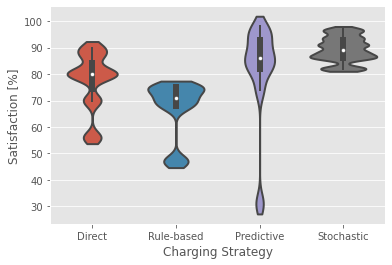

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ["Direct", "Rule-based", "Predictive", "Stochastic"]
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfcc4[dfcc4.stateOfCharge>30], x="phase", y="stateOfCharge", #palette="light:g",
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Satisfaction [%]")
ax.set_xticklabels(models)
#ax.set(ylim=(0, 100))

if writefiles:
    plt.savefig("output/chargingcomfort_strategies.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


## Departure Time per Vehicle

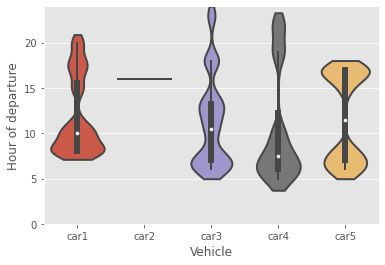

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfcc4, x="vehicle", y="hour",
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Vehicle")
ax.set_ylabel("Hour of departure")
ax.set(ylim=(0, 24))

if writefiles:
    plt.savefig("output/departuretimes_cars.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


todo: calculate PAPR per day  
todo: calculate EVSOC at first departure per day

#convert string to datetime
#df["runningdate"] =  pd.to_datetime(df["runningdate"]) 

#workaround to missing floor function in pandas
#df["runningdate"] = df.runningdate - pd.Timedelta(freq) # workaround to missing floor function in pandas
#df["runningdate"] = df["runningdate"].round(freq)

#filter for phase1
#df = df[(df["runningdate"] >= phase4) & (df["runningdate"] < end)]
#df.runningdate = pd.to_datetime(df.runningdate).round(freq='15T')
#df.set_index("runningdate", inplace=True, drop=True)


### Driving vs. Charging

In [27]:
#generate heat feature for plotting: heat = 1 ... charging, -1 ... driving
dfcc5 = dfcc2.reset_index()
dfcc5["heat"] = dfcc5.charging - dfcc5.driving
dfcc5.head()

,vehicle,timestamp,status,state,stateOfCharge,chgSOC,activePower-W,loadable,charging,driving,loadend,driveend,loadbeg,drivebeg,date,time,hour,dayofweek,phase,heat
0,car1,2022-03-07 00:00:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,2022-03-07,00:00:00,0,0,1,0.0
1,car1,2022-03-07 00:15:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,2022-03-07,00:15:00,0,0,1,0.0
2,car1,2022-03-07 00:30:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,2022-03-07,00:30:00,0,0,1,0.0
3,car1,2022-03-07 00:45:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,2022-03-07,00:45:00,0,0,1,0.0
4,car1,2022-03-07 01:00:00,idle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,2022-03-07,01:00:00,1,0,1,0.0


In [28]:
def car_heatmap(data, vehicle, phase, ax):
    my_ev = data[(data.vehicle == vehicle) & (data.phase == phase)]
    my_ev = my_ev.set_index("timestamp")
    my_ev = my_ev.resample("H").agg(
             {"heat": "mean"
              }
         ).pad()
    my_ev = my_ev.reset_index()

    #hour = my_ev["timestamp"].dt.hour
    date = my_ev["timestamp"].dt.date
    temp = my_ev["heat"]
    temp = temp.values.reshape(24, len(date.unique()), order="F")
    
    xgrid = np.arange(len(date.unique())+ 1) + 1
    ygrid = np.arange(25)
    
    ax.grid(False)
    ax.pcolormesh(xgrid, ygrid, temp, cmap="RdYlGn", vmin=MIN_TEMP, vmax=MAX_TEMP)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    #ax.yaxis.set_ticks([i for i in range(24)])
    ax.yaxis.set_ticks([0,6,12,18])
    ax.xaxis.set_ticks([i+1 for i in range(7)])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

    return ax


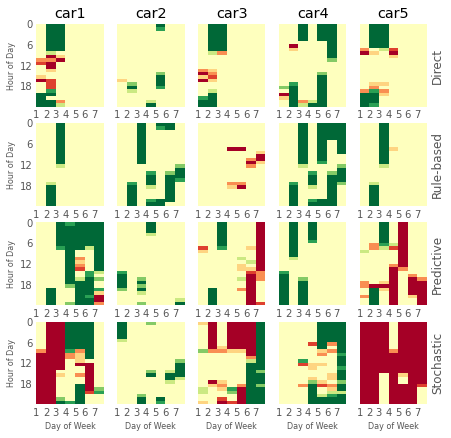

In [29]:
MIN_TEMP = dfcc5["heat"].min()
MAX_TEMP = dfcc5["heat"].max()

my_vehicles = dfcc5.vehicle.unique()
my_phases = [1,2,3,4]
models = ["Direct", "Rule-based", "Predictive", "Stochastic"]

fig, axes = plt.subplots(len(my_phases), len(my_vehicles), figsize=(7, 7), sharey=True)

for i, p in enumerate(my_phases):
    for j, v in enumerate(my_vehicles):
        myhm = car_heatmap(dfcc5, v, p, axes[i, j])
        if i == 0:
            myhm.set_title(v)
        if i == len(my_phases) - 1:
            myhm.set_xlabel("Day of Week", fontsize=8)
        if j == 0:
            myhm.set_ylabel("Hour of Day", fontsize=8)
        if j == len(my_vehicles) - 1:
            myhm.yaxis.set_label_position("right")
            #myhm.yaxis.tick_right()
            myhm.set_ylabel(models[i])

if writefiles:
    plt.savefig("output/charging_driving_cars.png",
                bbox_inches='tight', dpi=300)
    #plt.close()



## Peak Shaving

### get data


In [30]:
# execute SQL query
querypeak = open("sqls/opt_runs_15min.sql").read()
dfpeak = pd.read_sql_query(querypeak, conn)

# fix datatypes
dfpeak["runningdate"] =  pd.to_datetime(dfpeak["runningdate"]) 

# filter to daterange of field test
dfpeak = dfpeak[(dfpeak["runningdate"] >= phases["phase1"]) & (dfpeak["runningdate"] < phases["end"])]
dfpeak = dfpeak.set_index("runningdate")
dfpeak.head()

,phase,GridDraw
runningdate,,
2022-03-07 00:00:00,1,0.0
2022-03-07 00:15:00,1,0.0
2022-03-07 00:30:00,1,0.0
2022-03-07 00:45:00,1,0.0
2022-03-07 01:00:00,1,0.0


In [41]:
dfpeak2 = dfpeak["GridDraw"].resample('W').agg(["max", "mean", "std", mf.papr]).pad().round(2)
models = ["Direct", "Rule-based", "Predictive", "Stochastic"]
metrics = ["Maximum [kW]", "Average [kW]", "Std. Deviation [kW]", "PAPR"]
dfpeak2.index = models
dfpeak2.columns = metrics
dfpeak2 = dfpeak2 #.T #.reset_index()
dfpeak2

,Maximum [kW],Average [kW],Std. Deviation [kW],PAPR
Direct,35.00,21.65,14.64,1.62
Rule-based,35.00,12.81,7.34,2.73
Predictive,12.42,4.98,2.81,2.49
Stochastic,10.94,3.10,2.47,3.53


In [42]:
if writefiles:
    dfpeak2.to_latex(
        buf="output/peakshaving_strategies.tex", bold_rows=True)

C:\Users\alber\AppData\Local\Temp\ipykernel_19832\2864610043.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfpeak2.to_latex(


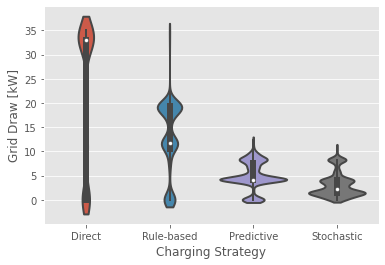

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfpeak, x="phase", y="GridDraw",
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Grid Draw [kW]")
ax.set_xticklabels(models)
#ax.set(ylim=(0, 24))

if writefiles:
    plt.savefig("output/peakshaving_strategies.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


## Running time

### get data

In [34]:
data = {}

#read logfile line by line
with open("../../data/lila/computations.log", 'r') as logfile:
    for line in logfile:
        split1 = line.split(' - ')
        timestamp = pd.Timestamp(split1[0])
        calctime = float(split1[3].split(': ')[2].split(' ')[0])
        data[timestamp] = calctime

#convert dictionary to dataframe
logdata = pd.DataFrame.from_dict(data, orient="index", columns=["calctime"])
logdata.index.name = "runningdate"

#remove index
logdata.reset_index(inplace=True)

#convert string to datetime
logdata["runningdate"] =  pd.to_datetime(logdata["runningdate"])

#workaround to missing floor function in pandas
logdata["runningdate"] = logdata.runningdate - pd.Timedelta(freq) # workaround to missing floor function in pandas
logdata["runningdate"] = logdata["runningdate"].round(freq)
logdata = logdata[(logdata["runningdate"] >= phases["phase1"]) & (logdata["runningdate"] < phases["end"])]

#restore index
logdata.set_index("runningdate", inplace=True)

#add field test phases
logdata["phase"] = 0
logdata.loc[phases["phase1"]:phases["phase2"], "phase"] = 1
logdata.loc[phases["phase2"]:phases["phase3"], "phase"] = 2
logdata.loc[phases["phase3"]:phases["phase4"], "phase"] = 3
logdata.loc[phases["phase4"]:phases["end"], "phase"] = 4

logdata.head()



,calctime,phase
runningdate,,
2022-03-07 00:00:00,2.826,1
2022-03-07 00:15:00,2.888,1
2022-03-07 00:30:00,1.863,1
2022-03-07 00:45:00,2.911,1
2022-03-07 01:00:00,2.791,1


In [35]:
dfrt_pivot_strategies = logdata.pivot_table(values="calctime", index="phase", aggfunc=["max", "min", "std", "mean"]).round(2)
models = ["Direct", "Rule-based", "Predictive", "Stochastic"]
dfrt_pivot_strategies.index = models
dfrt_pivot_strategies.columns.set_levels(["Maximum", "Minimum", "Std. Deviation", "Average"], level=0, inplace=True)
dfrt_pivot_strategies.columns.set_levels(["Computation Time [s]"], level=1, inplace=True)
dfrt_pivot_strategies

C:\Users\alber\AppData\Local\Temp\ipykernel_19832\1948798309.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfrt_pivot_strategies.columns.set_levels(["Maximum", "Minimum", "Std. Deviation", "Average"], level=0, inplace=True)
C:\Users\alber\AppData\Local\Temp\ipykernel_19832\1948798309.py:5: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfrt_pivot_strategies.columns.set_levels(["Computation Time [s]"], level=1, inplace=True)


,Maximum,Minimum,Std. Deviation,Average
,Computation Time [s],Computation Time [s],Computation Time [s],Computation Time [s]
Direct,216.26,0.26,22.58,6.09
Rule-based,600.44,1.64,198.01,167.48
Predictive,601.00,0.41,43.46,7.87
Stochastic,1197.99,1.02,422.96,617.54


In [36]:
if writefiles:
    dfrt_pivot_strategies.to_latex(
        buf="output/computationtime_strategies.tex", bold_rows=True)

C:\Users\alber\AppData\Local\Temp\ipykernel_19832\3319681876.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfrt_pivot_strategies.to_latex(


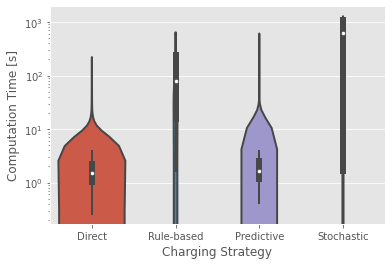

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=logdata, x="phase", y="calctime",
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_yscale("log")
ax.set_xticklabels(models)
#ax.set(ylim=(0, 1000))

if writefiles:
    plt.savefig("output/computationtime_strategies.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### analyze data

<AxesSubplot:xlabel='runningdate'>

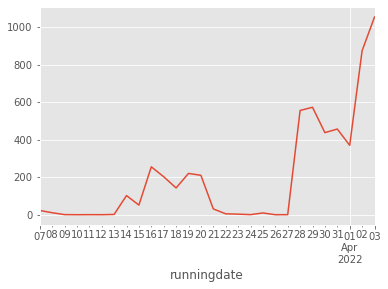

In [38]:
logdata.resample("D").mean()["calctime"].plot()

<AxesSubplot:ylabel='phase'>

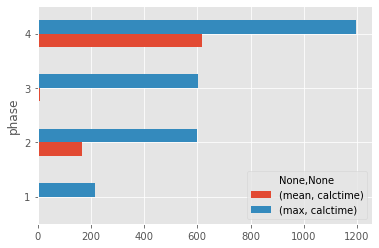

In [39]:
pd.pivot_table(logdata, values="calctime", index="phase", aggfunc=["mean", "max"]).round().plot(kind="barh")